In [25]:
using CSV, DataFrames, Statistics, GLMNet, DecisionTree, Random, ROCAnalysis, Plots, MLBase, NearestNeighbors, Makie

## 0. Cargamos los datos

Se cargan los datos y se preparan para utilizar en los algoritmos de clasificación, primero se elige el 70% de los datos totales como datos de entrenamiento y el 30% restante como datos de prueba. Además solo se usarán las columnas ["Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume", "Today"] como conjunto de datos ya que la columna "Year" nos da el año de los datos y no ofrece información relevante para la clasificación

In [39]:
# Charge de Data
df = CSV.read("Smarket.csv", DataFrame)

# Preparing Data for Regression
function clean_dataframe(df::DataFrame, valid_columns::Vector{String})
    # Seleccionar solo las columnas válidas
    df_subset = select(df, intersect(names(df), valid_columns))
    return df_subset
end
new_df = clean_dataframe(df, ["Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume", "Today", "Direction"])

# Hot Encoding for directions value
mapa_Direction = Dict("Up" => 1, "Down" => 0)
new_df.Direction = map(x -> mapa_Direction[string(x)], new_df.Direction);

# Preparar datos
# Dividir en entrenamiento y prueba
#shuffle!(new_df)
tamano_train = Int(0.7 * nrow(new_df));
datos_train = new_df[1:tamano_train, :];
datos_test = new_df[tamano_train+1:end, :];
X = (Matrix(select(datos_train, Not(:Direction))));  # Los datos de entrada de entrenamiento
y= vec(Matrix(select(datos_train, :Direction)));  # Las etiquetas de entrenamiento (sin necesidad de convertir a Matrix)
X_test = (Matrix(select(datos_test, Not(:Direction))));  # Los datos de entrada de prueba
y_test = vec(Matrix(select(datos_test, :Direction))); # Las etiquetas de prueba (sin necesidad de convertir a Matrix)

# Crea un DataFrame con las etiquetas reales
results = DataFrame(y_test=y_test)

375×1 DataFrame
 Row │ y_test 
     │ Int64  
─────┼────────
   1 │      1
   2 │      1
   3 │      1
   4 │      0
   5 │      0
   6 │      0
   7 │      0
   8 │      1
   9 │      0
  10 │      1
  11 │      0
  ⋮  │   ⋮
 366 │      0
 367 │      0
 368 │      0
 369 │      1
 370 │      1
 371 │      1
 372 │      0
 373 │      1
 374 │      0
 375 │      0
354 rows omitted

## 1. LASSO

Para Lasso usamos la libreria GLMNet considerando $\alpha = 1$, haciendo Cross Validation encontramos el $\lambda$ que clasifique mejor los datos y se hace la predicción del modelo con el $\lambda$,  se tiene que crear además una función que asigne una clase, esto debido a que se obtienen valores continuos.

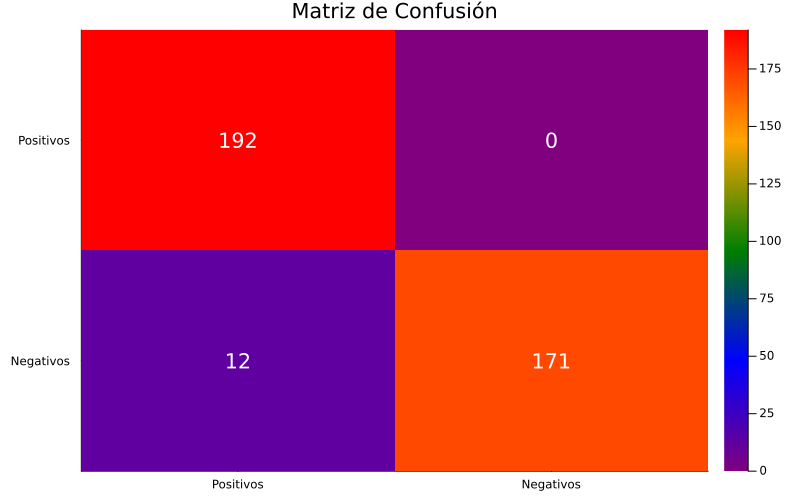

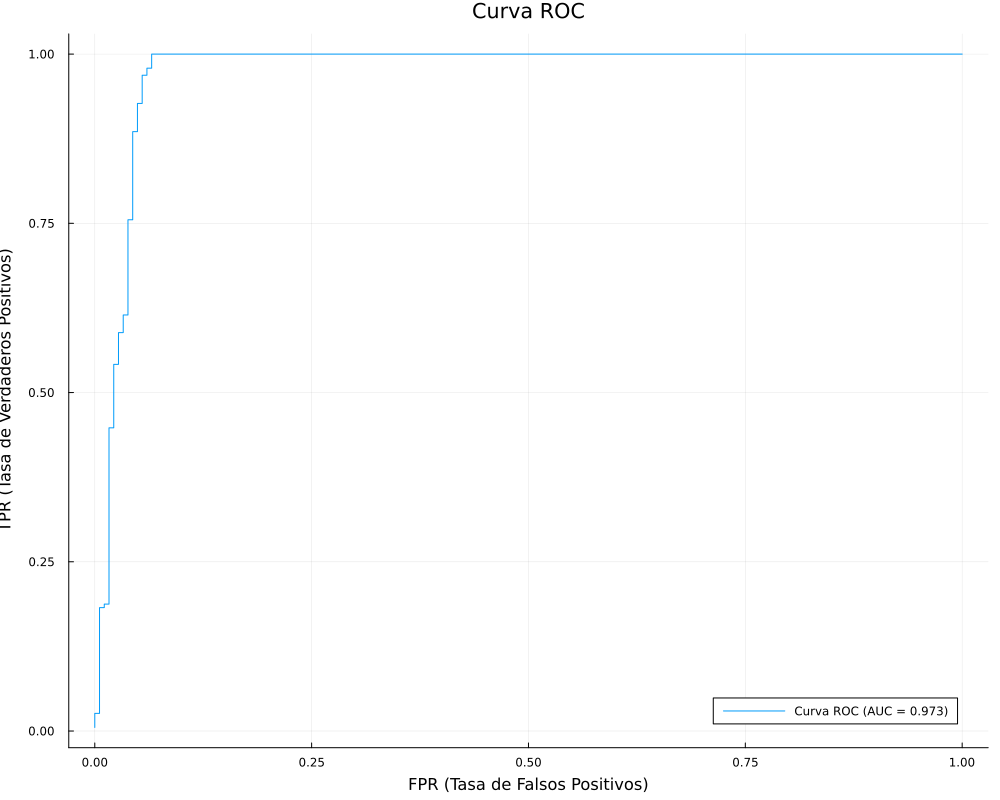

"/Users/paini/Desktop/DiplomadoAI24-25/Asignments/Exercise 3/ROC_Lasso.png"

In [28]:
# 1. LASSO (alpha=1.0)
path = glmnet(X, y)
cv = glmnetcv(X, y)
mylambda = path.lambda[argmin(cv.meanloss)];
model = glmnet(X, y,lambda=[mylambda]);
q = X_test;
predictions_lasso = GLMNet.predict(model, q);
predictions_lasso = [if x < 0.5 0 else 1 end for x in predictions_lasso];
predictions_lasso = vec(predictions_lasso);
results.Lasso = predictions_lasso;
ConfusionMatrix(results.y_test, results.Lasso, "Lasso")
ROCCurve(results.y_test, results.Lasso, "Lasso")

## 2. Ridge

Para Ridge usamos la libreria GLMNet considerando $\alpha = 0.0$, haciendo Cross Validation encontramos el $\lambda$ que clasifique mejor los datos y se hace la predicción del modelo con el $\lambda$, se tiene que crear además una función que asigne una clase, esto debido a que se obtienen valores continuos.

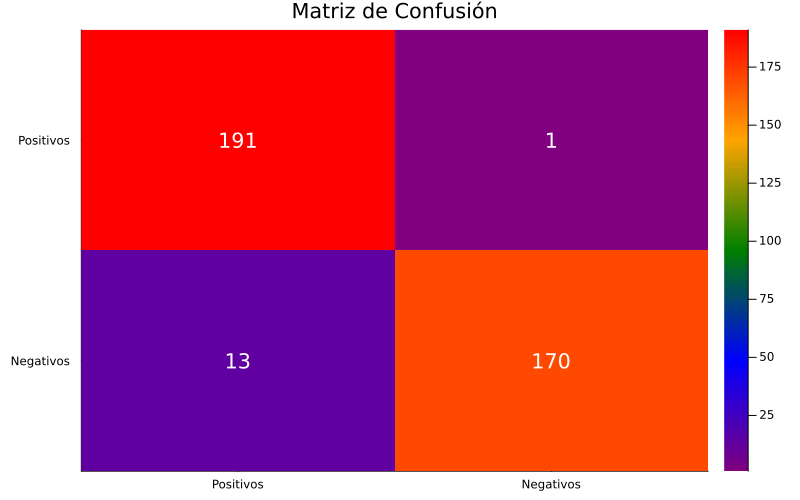

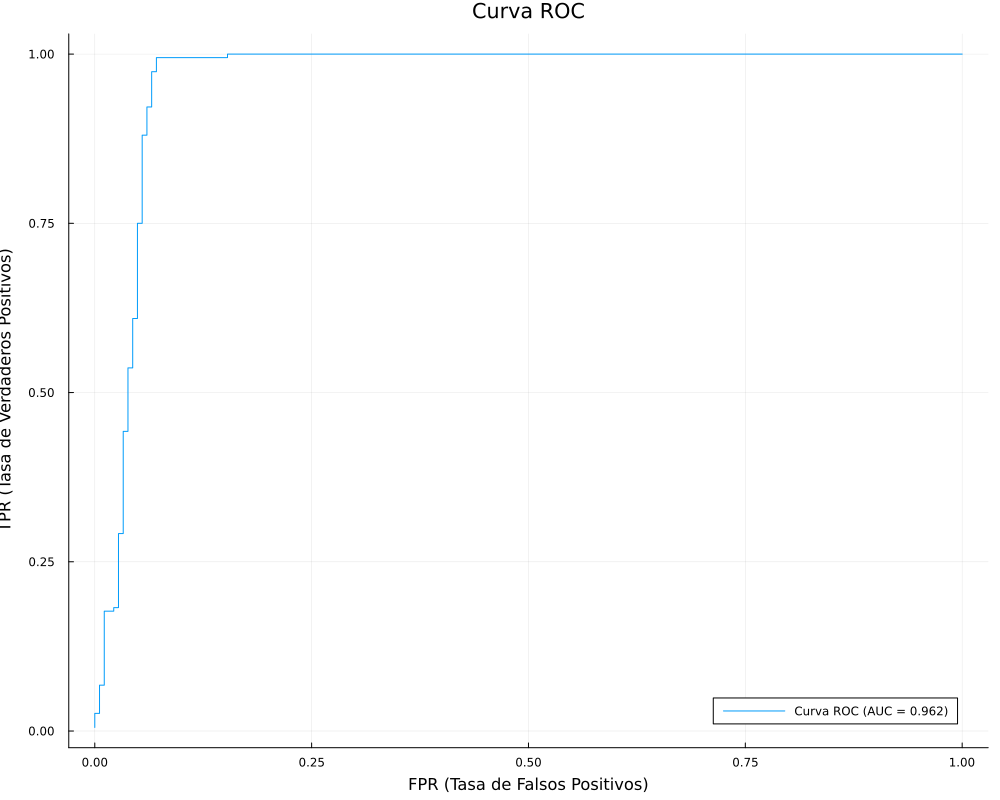

"/Users/paini/Desktop/DiplomadoAI24-25/Asignments/Exercise 3/ROC_Ridge.png"

In [29]:
# 2. Ridge (alpha=0.0)
path = glmnet(X, y, alpha=0)
cv = glmnetcv(X, y, alpha=0)
mylambda = path.lambda[argmin(cv.meanloss)]
model = glmnet(X, y, alpha=0, lambda=[mylambda]);
q = X_test;
predictions_ridge = GLMNet.predict(model, q);
predictions_ridge = [if x < 0.5 0 else 1 end for x in predictions_ridge];
predictions_ridge = vec(predictions_ridge);
results.Ridge = predictions_ridge;
ConfusionMatrix(results.y_test, results.Ridge, "Ridge")
ROCCurve(results.y_test, results.Ridge, "Ridge")

## 3. Elastic Net

Para Elastic Net usamos la libreria GLMNet considerando $\alpha = 0.5$, haciendo Cross Validation encontramos el $\lambda$ que clasifique mejor los datos y se hace la predicción del modelo con el $\lambda$, se tiene que crear además una función que asigne una clase, esto debido a que se obtienen valores continuos.

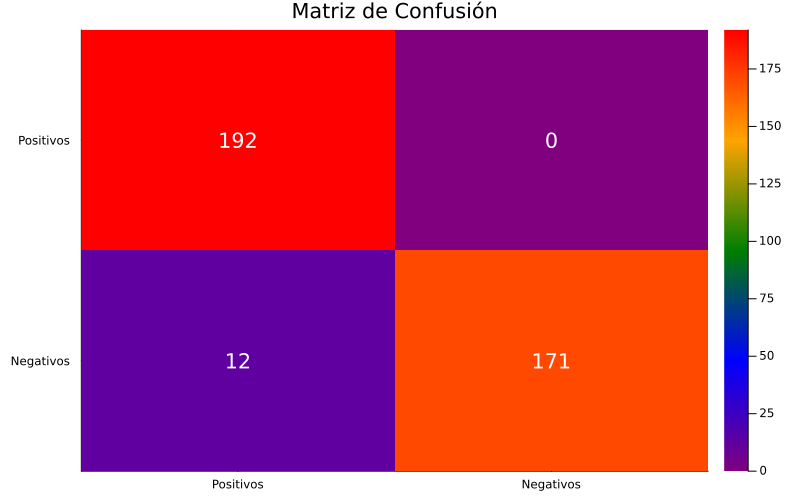

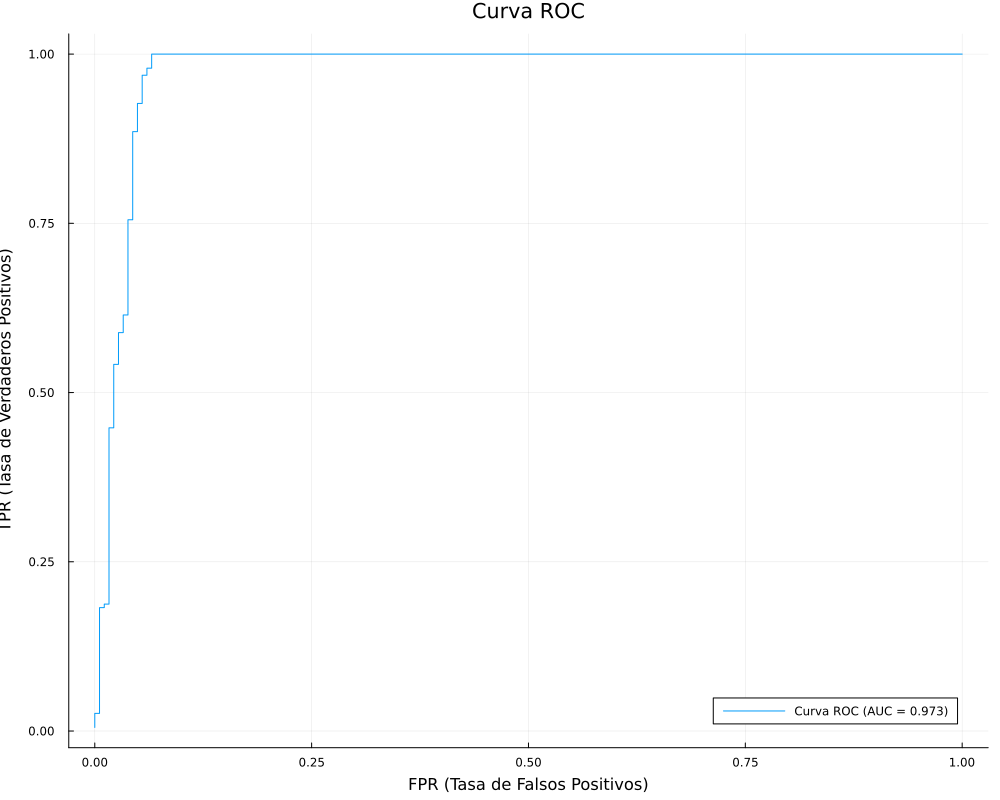

"/Users/paini/Desktop/DiplomadoAI24-25/Asignments/Exercise 3/ROC_ElasticNet.png"

In [30]:
# 3. Elastic Net (alpha=0.5)
path = glmnet(X, y, alpha=0.5)
cv = glmnetcv(X, y, alpha=0.5)
mylambda = path.lambda[argmin(cv.meanloss)]
model = glmnet(X, y, alpha=0.5, lambda=[mylambda]);
q = X_test;
predictions_EN = GLMNet.predict(model, q);
predictions_EN = GLMNet.predict(model, q);
predictions_EN = [if x < 0.5 0 else 1 end for x in predictions_EN];
predictions_EN = vec(predictions_EN);
results.ElasticNet = predictions_EN
ConfusionMatrix(results.y_test, results.ElasticNet, "ElasticNet")
ROCCurve(results.y_test, results.ElasticNet, "ElasticNet")

## 4. Decision Tree

Para Decision Tree usamos la libreria DecisionTree. 
Se crea un modelo de árbol de decisión con una profundidad máxima de 2, lo que limita la complejidad del árbol. Se ajusta el modelo a los datos de entrada `X` y sus respectivas etiquetas `y` utilizando el método `fit!` de la librería `DecisionTree`.

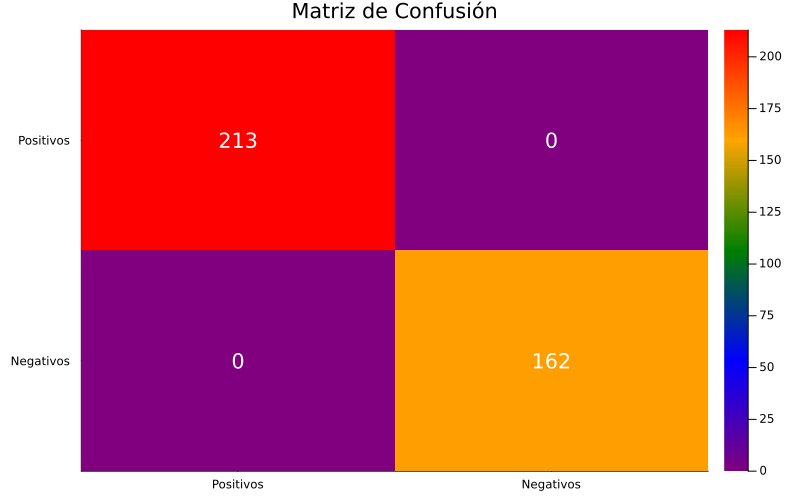

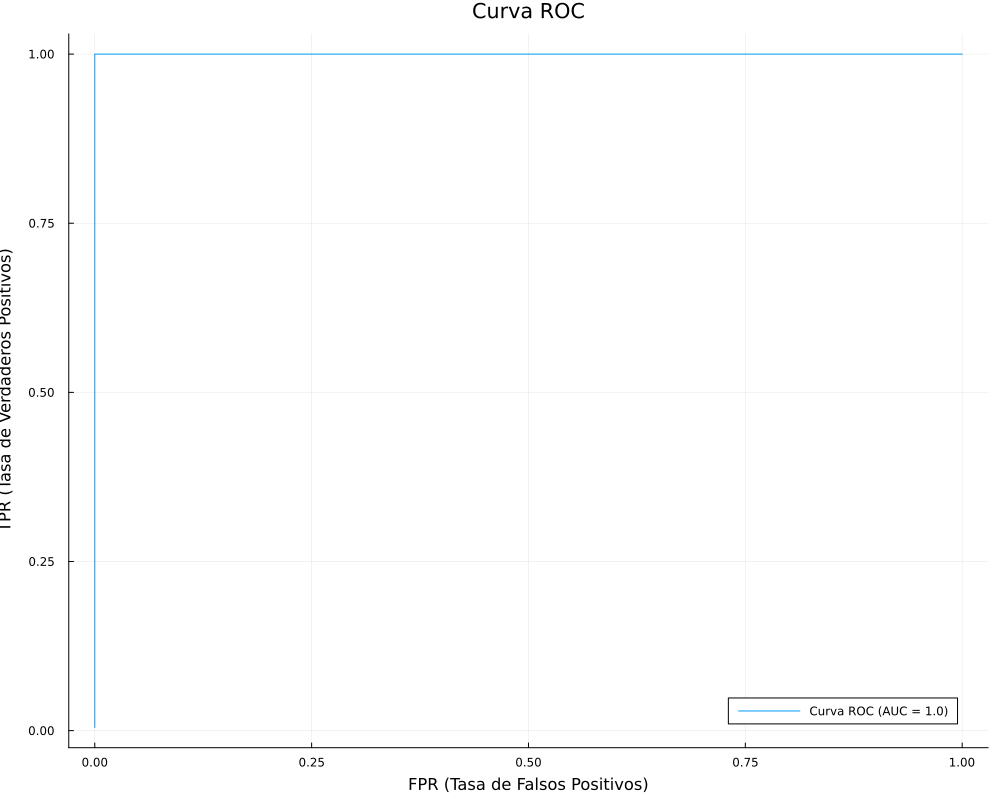

"/Users/paini/Desktop/DiplomadoAI24-25/Asignments/Exercise 3/ROC_DecisionTree.png"

In [40]:
# 4. Decision Tree 
model = DecisionTreeClassifier(max_depth=2)
DecisionTree.fit!(model, X, y)
q = X_test;
predictions_DT = DecisionTree.predict(model, q);
predictions_DT = vec(predictions_DT);
results.DecisionTree = predictions_DT;
ConfusionMatrix(results.y_test, results.DecisionTree, "DecisionTree")
ROCCurve(results.y_test, results.DecisionTree, "DecisionTree")

## 5. Bosque Aleatorio (Random Forest)

En este bloque de código se entrena y evalúa un modelo de bosque aleatorio para la clasificación utilizando el conjunto de datos de entrenamiento.
Se crea un modelo de bosque aleatorio con 20 árboles de decisión. El número de árboles determina la cantidad de modelos individuales que se entrenan para hacer predicciones.
Aunque se menciona `DecisionTree`, la función `fit!` entrena el modelo de bosque aleatorio `model` utilizando los datos de entrada `X` y las etiquetas correspondientes `y`.


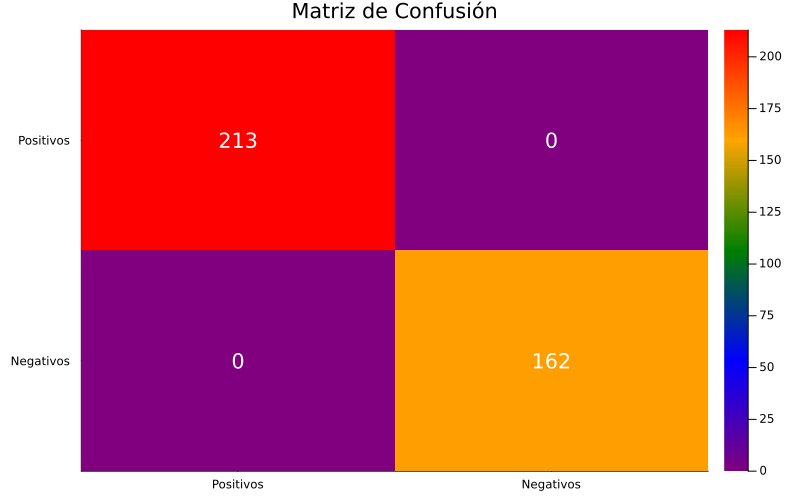

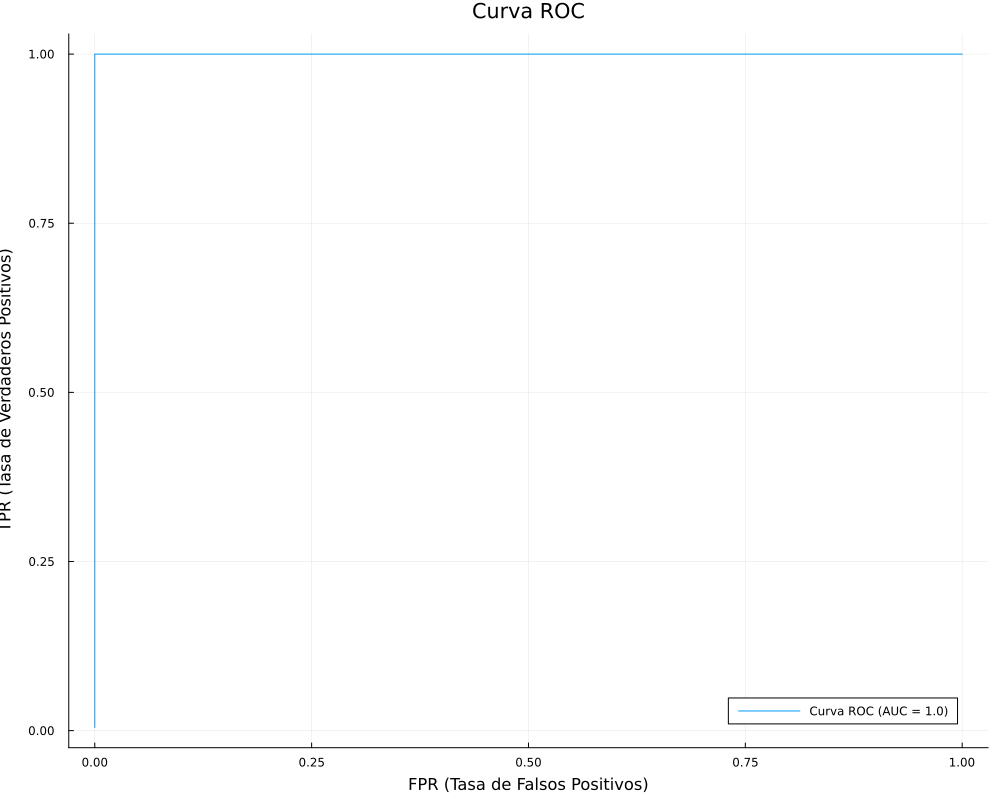

"/Users/paini/Desktop/DiplomadoAI24-25/Asignments/Exercise 3/ROC_RandomForest.png"

In [41]:
# 5. Random Forest
model = RandomForestClassifier(n_trees=20)
DecisionTree.fit!(model, X, y)
q = X_test;
predictions_RF = DecisionTree.predict(model, q)
predictions_RF = vec(predictions_RF)
results.RandomForest = predictions_RF
ConfusionMatrix(results.y_test, results.RandomForest, "RandomForest")
ROCCurve(results.y_test, results.RandomForest, "RandomForest")

## 6. Nearest Neighbor
Este bloque de código utiliza el algoritmo de K vecinos más cercanos (KNN) para hacer predicciones sobre el conjunto de datos de prueba.
Se construye un árbol KD (K-Dimensional Tree) con los datos de entrada `X`. Este árbol permite realizar búsquedas de vecinos más cercanos de manera eficiente.
Se realiza una consulta para encontrar los 5 vecinos más cercanos para cada punto del conjunto de prueba `X_test`. El resultado es un par de vectores: `idxs`, que contienen los índices de los vecinos más cercanos, y `dists`, que contienen las distancias correspondientes.

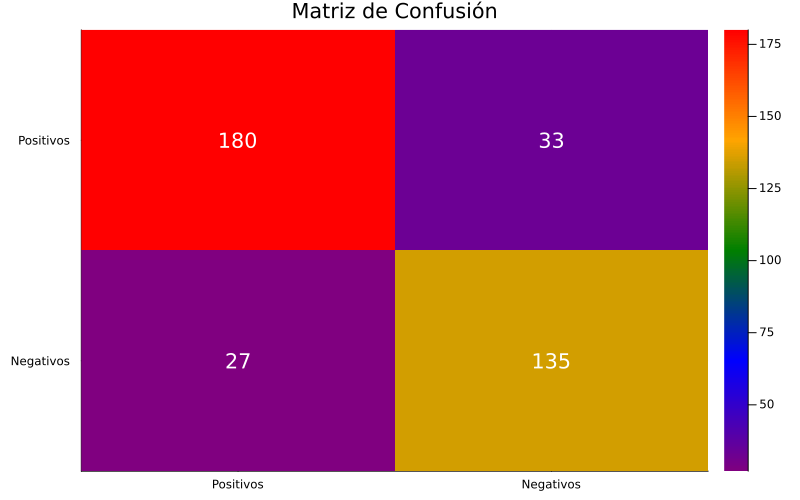

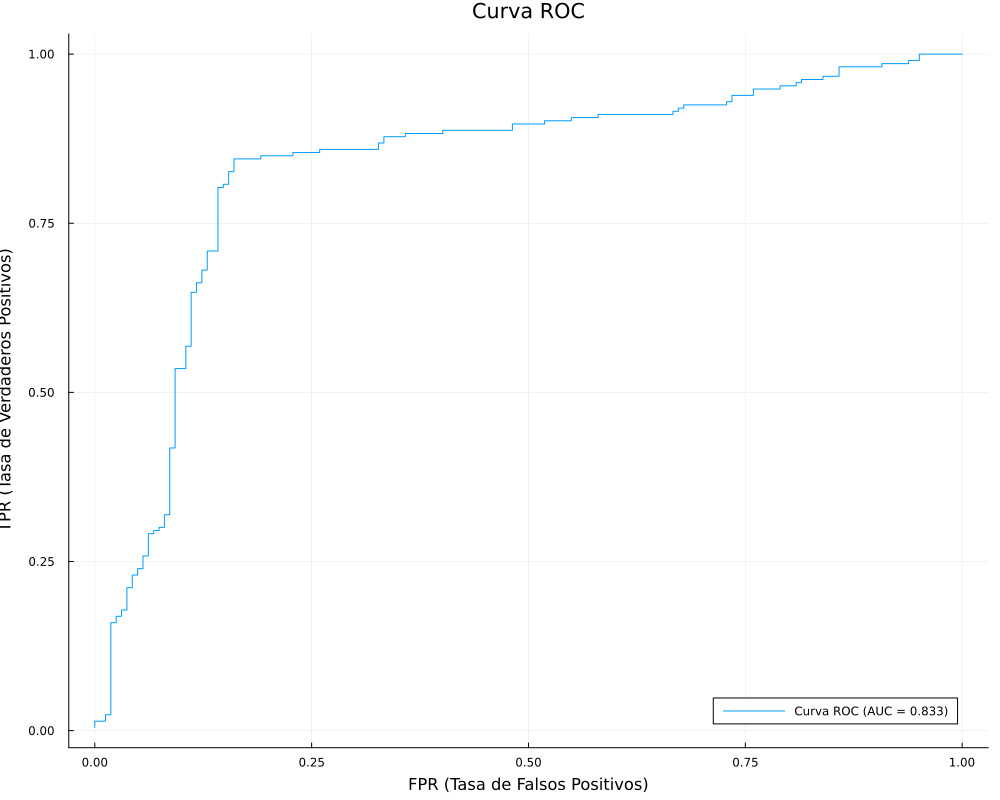

"/Users/paini/Desktop/DiplomadoAI24-25/Asignments/Exercise 3/ROC_NearestNeighbor.png"

In [42]:
# 6. Nearest Neighbor
kdtree = KDTree(X')
queries = X_test
idxs, dists = knn(kdtree, queries', 5, true)
neighbors_labels = y[hcat(idxs...)]
predictions_NN = map(i -> mean(neighbors_labels[:, i]) > 0.5 ? 1 : 0, 1:size(neighbors_labels, 2));
predictions_NN = vec(predictions_NN);
results.NearestNeighbor = predictions_NN;
ConfusionMatrix(results.y_test, results.NearestNeighbor, "NearestNeighbor")
ROCCurve(results.y_test, results.NearestNeighbor, "NearestNeighbor")

## 7. Support Vecror Machines (SVM)
Se entrena un modelo de SVM utilizando los datos de entrada `X` (transpuestos para que las características sean las filas) y las etiquetas `y`.


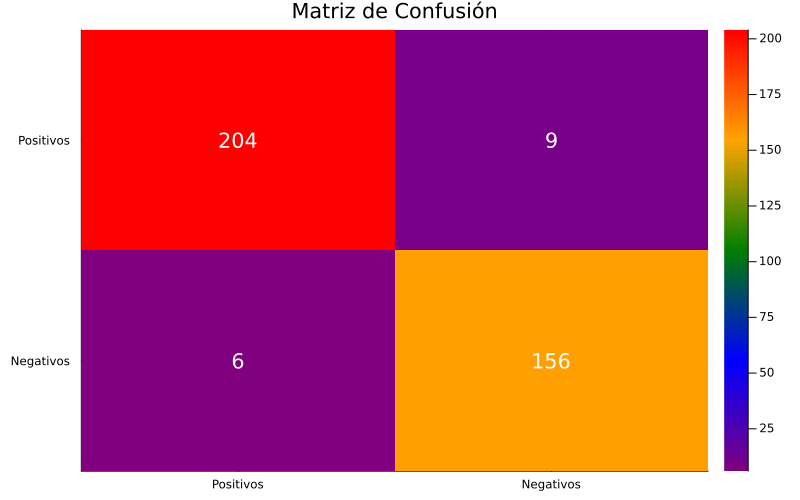

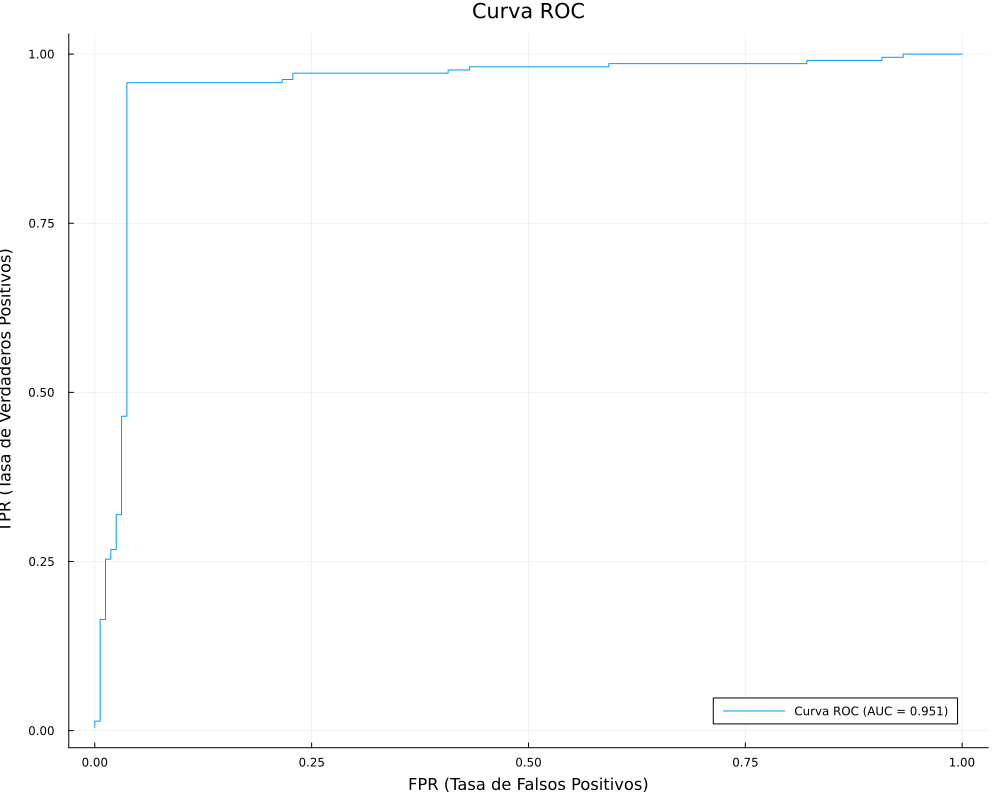

"/Users/paini/Desktop/DiplomadoAI24-25/Asignments/Exercise 3/ROC_SupportVectorMachine.png"

In [43]:
# 7. Support Vecror Machines (SVM)
model = svmtrain(X', y)
predictions_SVM, decision_values = svmpredict(model, X_test')
predictions_SVM = vec(predictions_SVM)
results.SupportVectorMachine = predictions_SVM
ConfusionMatrix(results.y_test, results.SupportVectorMachine, "SupportVectorMachine")
ROCCurve(results.y_test, results.SupportVectorMachine, "SupportVectorMachine")

In [44]:
# Mostrar el DataFrame con las predicciones de cada modelo
println(results)

375×5 DataFrame
 Row │ y_test  DecisionTree  RandomForest  NearestNeighbor  SupportVectorMachine 
     │ Int64   Int64         Int64         Int64            Int64                
─────┼───────────────────────────────────────────────────────────────────────────
   1 │      1             1             1                1                     1
   2 │      1             1             1                1                     1
   3 │      1             1             1                1                     1
   4 │      0             0             0                1                     0
   5 │      0             0             0                0                     0
   6 │      0             0             0                0                     0
   7 │      0             0             0                1                     1
   8 │      1             1             1                1                     1
   9 │      0             0             0                0                     0
  10 │   

In [27]:
function ConfusionMatrix(y_test, y_pred, name)
    confusionmatrix = MLBase.roc(y_test, y_pred)
    # Extraer valores del objeto confusionmatrix
    tp = confusionmatrix.tp  # Verdaderos Positivos
    tn = confusionmatrix.tn  # Verdaderos Negativos
    fp = confusionmatrix.fp  # Falsos Positivos
    fn = confusionmatrix.fn  # Falsos Negativos

    m_c = [fp tn; tp fn]

    for i in 1:size(m_c, 1)
        for j in 1:size(m_c, 2)
            annotate!(j, i, Plots.text(string(m_c[i, j]), :white, 14))
        end
    end

   # Coordenadas de los cuadros para las anotaciones
    rows, cols = size(m_c)
    x_coord = repeat(1:cols, inner=rows)
    y_coord = repeat(1:rows, outer=cols)


    # Texto con los valores de la matriz
    texto = vec(string.(m_c))

    # Graficar la matriz de confusión
    fig = Plots.heatmap(
        m_c,
        title="Matriz de Confusión",
        c=:rainbow,
        xticks=(1:2, ["Positivos", "Negativos"]),
        yticks=(1:2, ["Negativos", "Positivos"]),
        colorbar=true,
        annotations=(x_coord, y_coord, texto, :white),
        size=(800, 500)
    )
    # Crear un nombre de archivo único con 'y_pred'
    y_pred_name = string("confusion_", name)  
    # Guardar la figura con un nombre dinámico basado en y_pred
    display(fig)
    savefig("$y_pred_name.png")
end

ConfusionMatrix (generic function with 1 method)

In [26]:
function ROCCurve(y_test, y_pred, name)
    # Ordenar por probabilidades predichas en orden descendente
    sorted_indices = sortperm(y_pred, rev=true)
    sorted_probs = y_pred[sorted_indices]
    sorted_labels = y_test[sorted_indices]

    # Inicializar variables
    tpr = Float64[]  # Verdadero positivo rate (True Positive Rate)
    fpr = Float64[]  # Falso positivo rate (False Positive Rate)
    tp = 0
    fp = 0
    p = sum(sorted_labels)  # Total de positivos
    n = length(sorted_labels) - p  # Total de negativos

    # Calcular TPR y FPR en cada umbral
    for i in 1:length(sorted_probs)
        if sorted_labels[i] == 1
            tp += 1
        else
            fp += 1
        end
        push!(tpr, tp / p)
        push!(fpr, fp / n)
    end

    # Calcular AUC usando la regla trapezoidal
    auc = sum((tpr[2:end] + tpr[1:end-1]) .* (fpr[2:end] - fpr[1:end-1]) / 2)

    # Graficar curva ROC
    fig = Plots.plot(
        fpr,
        tpr,
        label="Curva ROC (AUC = $(round(auc, digits=3)))",
        xlabel="FPR (Tasa de Falsos Positivos)",
        ylabel="TPR (Tasa de Verdaderos Positivos)",
        title="Curva ROC",
        legend=:bottomright,
        size=(1000, 800)
    )
    # Crear un nombre de archivo único con 'y_pred'
    y_pred_name = string("ROC_", name)  
    # Guardar la figura con un nombre dinámico basado en y_pred
    display(fig)
    savefig("$y_pred_name.png")

end

ROCCurve (generic function with 1 method)

In [24]:
for col_name in names(results)  # Iterar sobre los nombres de las columnas
    col = results[:, col_name]  # Seleccionar la columna
    if col_name != "y_test"  # Evitar pasar 'y_test' como predicción
        ConfusionMatrix(results.y_test, col, col_name)
        ROCCurve(results.y_test, col, col_name)
    end
end